# Generate sample dataset

In [33]:
import numpy as np
import random as rd
import math
import pandas as pd
from numpy import log2 as log
import pprint
eps = np.finfo(float).eps

In [50]:
class datagen:
    def __init__(self, m):
#         self.k = k # number of features
        self.m = m # number of data points
        self.arrofarrX = []
        self.arrY = []
        
        for i in range(self.m):
            tmpX = self.generateX()
            tmpY = self.computeY(tmpX)
            self.arrofarrX.append(tmpX)
            self.arrY.append(tmpY)
            
        self.df = pd.DataFrame(d.arrofarrX)
        L = len(d.arrofarrX[0])
        self.df['Y'] = d.arrY
        
    def ran(self,x,y):
        if rd.uniform(x,y) > 0.5:
            return 1
        else:
            return 0
    
    def ran2(self,x,y):
        if rd.uniform(x,y) > 0.25:
            return 1
        else:
            return 0
        
    def generateX(self):
        new = []
        if self.ran(0,1) == 1:
            new.append(1)
        else:
            new.append(0)
        
        for x in range(1,14):
            if self.ran2(0,1) == 1:
                new.append(new[x-1])
            else:
                new.append(1-new[x-1])
        for x in range(15,21):
            if self.ran(0,1) == 1:
                new.append(0)
            else:
                new.append(1)
        return new
    
    def computeY(self,arrX):
        res = 0
        count0 = 0
        count1 = 0
        if arrX[0] == 0:
            for x in range(1,8):
                if arrX[x] == 0:
                    count0+=1
                else:
                    count1+=1
        else:
            for x in range(8,15):
                if arrX[x] == 0:
                    count0+=1
                else:
                    count1+=1
        
        if count0 > count1:
            return 0
        else:
            return 1

# Building Decision Tree

# Compute $H(Y)$

In [54]:
def find_entropy(df):
    ClFI = df.keys()[-1]   # to get the attribute name of classifcation column
    entropy = 0
    values = df[ClFI].unique()
    for value in values:
        fraction = df[ClFI].value_counts()[value]/len(df[ClFI])
        entropy += -fraction*np.log2(fraction)
    return entropy

# Compute $H(Y|X) = \sum_{x}P(X = x)[-\sum_{y}P(Y=y|X=x)\log P(Y=y|X=x)]$

In [55]:
def find_entropy_attribute(df,attribute):
    ClFI = df.keys()[-1]      
    target_variables = df[ClFI].unique()  
    variables = df[attribute].unique()    
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[ClFI] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)

# Find the attribute that could lead to biggest entropy

In [57]:
def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
#         Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]

# get subtable since we find a attribute to cut the table

In [58]:
def get_subtable(df, node,value):
    return df[df[node] == value].reset_index(drop=True)

# (DFS IMPLEMENTATION)FINAL STEP: LETS BUILD DECISION TREE

In [59]:
def buildTree(df,tree=None): 
    Class = df.keys()[-1]   
    
    node = find_winner(df)   #get the attribute that could lead to he biggest entropy
    
    attValue = np.unique(df[node])   #get the distint attribute in the colomen which lead to the
                                     #biggest entrophy
    
    #init a dictonary structure to store the entire decision tree
    # which is a dictionary of dictionary
    # the innder dictionary used to store the current layer of decision tree
    if tree is None:                    
        tree={}
        tree[node] = {}
    
    #find the index of last column
    
    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable['Y'],return_counts=True)    #based on the subtable, if counts of unique array
                                                                        #equals one, means only one case exist to decide Y
        if len(counts)==1:
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) #DFS 
                   
    return tree

# Prediction function: input 1 is the decision tree, input 2 is the dataset that need to be predicted

In [60]:
def predict(pred_arr,tree):     #predict function is just to traverse the TREE using DFS 
    #DFS
    for node in tree.keys():
        value = pred_arr[node]
        tree = tree[node][value]
        ans = 0
        if type(tree) is dict:  # yet to reach the node
            ans = predict(pred_arr,tree)
        else:
            ans = tree
            break;
    return ans

# Compute the training error

In [79]:
def err_train(df,tree):
    count = 0
    l = len(df)
    for x in range(l):
        inst = df.iloc[x]
        ans = predict(inst,tree)
        if ans == inst[-1]:
            count+=1
        inst = 0
    return (l-count)/l

#  

# Quesiton (1), consider $m$ ranges from 10 to 10000, each time we use 80% dataset to train decision tree, and 20% dataset to predict

In [83]:
err_history = []
count = 0
x_axis = []
for m in range(10,100):
    d = datagen(m)
    df = d.df
    trainset, predictset = np.split(df, [int(.8*len(df))])   #80% training set, 20% predicting set
    predictset.index = range(len(predictset.index))          #reindex the index of predicting set from zero to len-1
    tree = buildTree(trainset)                               #build decision tree using training set
#     errtrain = err_train2(trainset,tree)
    errpred = err_train(predictset,tree)
    err_history.append(errpred)
    x_axis.append(count)
    count = count + 1

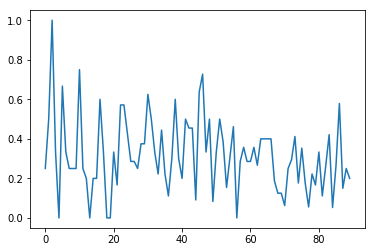

In [84]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_axis, err_history)

# Question(2) 

# Count number of irrelevent variables function in tree

In [244]:
def countirr(tree):
    #level order traverse tree
    if tree is None:
        return
    #create queue for level order trasversal
    
    ans = []
    queue = []
    key = list(tree.keys())
    p = [key[0],tree]
    queue.append(p)
    ans.append(key[0])
    while(len(queue)>0):
        pair = queue.pop(0)
        node = pair[0]
        tree = pair[1]
        ans.append(node)
        tree0 = tree[node][0]
        tree1 = tree[node][1]
        if type(tree0) is dict:
            key = list(tree0.keys())
            pair = [key[0],tree0]
            queue.append(pair)
            
        if type(tree1) is dict:
            key = list(tree1.keys())
            pair = [key[0],tree1]
            queue.append(pair)
            
    ans = list(set(ans))  # get unique node number
    return ans

In [286]:
def height(tree):
    if type(tree) is not dict:
        return 0
    else:
        for node in tree.keys():
            treeleft = tree[node][0]
            lheight = height(treeleft)
            treeright = tree[node][1]
            rheight = height(treeright)
        
        if lheight > rheight :
            return lheight + 1
        else:
            return rheight + 1
        

In [301]:
def countirrela(arr):
    count= 0
    for i in range(len(arr)):
        if arr[i]>=15 and arr[i]<=20:
            count+=1
    return count

In [317]:
err_history = []
irre_history = []
m = 0
x_axis = []
for m in range(10,100):
    value = 0.0
    errvalue = 0.0
    for i in range(10):
        d = datagen(m)
        df = d.df
        trainset, predictset = np.split(df, [int(.8*len(df))])
        predictset.index = range(len(predictset.index))         
        tree = buildTree(trainset)
        errpred = err_train(predictset,tree)
        errvalue+=errpred
        arrofirreindex = countirr(tree)
        irre_count = countirrela(arrofirreindex)
        value+=irre_count
    average = value/10
    ave_errvalue = errvalue/10
    err_history.append(ave_errvalue)
    x_axis.append(m)
    irre_history.append(average)
    print(m)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


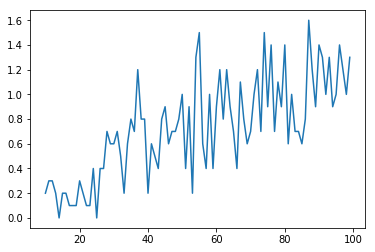

In [318]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_axis, irre_history)